<a href="https://colab.research.google.com/github/yh0010/NYU_Summer_Tandon_Scholar_Intro2ML/blob/main/ElainaH_5_hw_voter_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Voter classification using exit poll data


**TODO**: Edit this cell to fill in your NYU Net ID and your name:

-   **Net ID**: yh4310
-   **Name**: Elaina Huang

In this notebook, we will explore the problem of voter classification.

Given demographic data about a voter and their opinions on certain key issues, can we predict their vote in the 2016 U.S. presidential election? We will attempt this using a K nearest neighbor classifier.

In the first part of this notebook, I will show you how to train and use a K nearest neighbors classifier for this task. In the next part of the notebook, you will try to improve the basic model for better performance.


## Import libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import nan_euclidean_distances

We will need to install a library that is not in the default Colab environment, which we can install with `pip`:

In [ ]:
!pip install category_encoders

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 31116396_National2016.csv to 31116396_National2016 (2).csv
User uploaded file "31116396_National2016.csv" with length 26283642 bytes


Then, use the `read_csv` function in `pandas` to read in the file. 

Also use `head` to view the first few rows of data and make sure that everything is read in correctly.

In [ ]:
df = pd.read_csv('31116396_National2016.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
0,135355,Hillary Clinton,The Democratic candidate,6.530935,,18-29,18-29,18-24,18-44,18-49,18-29,18-24,Non-Black 18-29,Latino 18-29,Latino 18-29,,,,Complete,,,,,,,30,,,,,,,,,,,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Hispanic/Latino,West,,,,,Female,Latino women,Married women,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In October,In the last month,Before that,,,,,,,,,Version 1,,,No,,,
1,135356,Hillary Clinton,The Democratic candidate,6.479016,,18-29,18-29,25-29,18-44,18-49,18-29,25-29,Non-Black 18-29,Latino 18-29,Latino 18-29,,,,Complete,,,,,,,44,,,,,,,,,,,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Hispanic/Latino,West,,,,,Male,Latino men,Married men,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In October,In the last month,Before that,,,,,,,,,Version 1,,,No,,,
2,135357,Hillary Clinton,The Democratic candidate,8.493230,,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,,,,Complete,,,,,,,6,,,,,,,,,,,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Asian,West,,,,,Male,All other races,Married men,"Cities 50,000-500,000","Cities over 50,000",English,,California,Other,,,Telephone survey,,,,In September,Before that,Before that,,,,,,,,,Version 1,,,No,,,
3,135358,Hillary Clinton,The Democratic candidate,3.761814,,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,,,,Complete,,,,,,,11,,,,,,,,,,,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Other,West,,,,,Female,All other races,Non married women,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In the last week,In the last month,In the last week,,,,,,,,,Version 1,,,No,,,
4,135359,Hillary Clinton,The Democratic candidate,3.470473,,45-65,30-59,45-49,45+,18-49,45-59,40-49,Black 45-59,Black 45-59,Black 45-64,,,,Complete,,,,,,,37,,,,,,,,,,,Postgraduate study,College graduate,More than High school graduate,Non white college degree,...,Non-white,Black,West,,,,,Female,Black women,Non married women,"Cities over 500,000","Cities over 50,000",English,,California,Other,,,Telephone survey,,,,Before that,Before that,Before that,,,,,,,,,Version 1,,,No,,,


In [ ]:
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df['VERSION'].value_counts()

Version 2    5126
Version 1    5094
Version 3    4980
Version 4    4919
Version 5    4915
Name: VERSION, dtype: int64

In a red box next to each question, you can also see the name of the variable (column name) that the respondent's answer will be stored in.

Because each respondent answers different questions, for each row in the data, only some of the columns - the columns corresponding to questions included in that version of the survey - have data.

### Missing data

Since each respondent only saw a subset of questions, we expect to see missing values in each column.

However, if we look at the **count** of values in each column, we see that there are no missing values - every column has the full count!

In [ ]:
df.describe(include='all')

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
count,25034.000000,25034,25034,25034.000000,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034.000000,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,...,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034
unique,NaN,7,5,NaN,5,5,4,9,3,3,5,7,9,14,14,5,3,6,2,3,6,4,4,3,4,NaN,4,4,6,4,6,4,4,6,4,5,5,3,3,5,...,3,7,4,5,6,9,6,3,8,5,5,3,3,6,51,4,6,4,2,4,6,4,7,4,4,4,5,4,6,4,6,4,3,5,3,7,3,3,3,4
top,NaN,Hillary Clinton,The Democratic candidate,NaN,,45-65,30-59,50-59,45+,18-49,45-59,50-64,Non-Black 45-59,White 60+,White 45-64,,,,Complete,,,,,,Call 1,NaN,,,,,,,,,,,Some college/assoc. degree,No college degree,More than High school graduate,White college degree,...,White,White,South,,,,,Female,White women,,Suburbs,Suburbs,,,California,Other,,,Election day exit poll,,,,,,,,,,,,,,,Version 2,,,,,,
freq,NaN,12126,12041,NaN,15568,9746,13697,5071,14436,12836,7490,7327,6438,5562,7050,20387,20387,20894,24253,20164,20786,20786,20786,20284,7143,NaN,20251,20058,20284,20284,20251,20251,20284,20284,23788,20058,7835,11959,19783,8812,...,17536,14800,7246,16656,16656,16656,19142,13742,9491,15409,11966,11966,17385,11812,2559,16333,20119,20119,20660,20058,20058,20058,20123,20123,20123,20284,20054,20058,20251,20251,20284,20284,20324,5126,20387,16441,15521,20137,20503,22181
mean,188663.858712,NaN,NaN,1.003016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.672246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,27829.369563,NaN,NaN,1.065169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.941176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,135355.000000,NaN,NaN,0.047442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,175885.250000,NaN,NaN,0.525367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,193824.500000,NaN,NaN,0.745491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

This is because missing values are recorded as a single space, and not with a NaN. 

Let's change that:

In [ ]:
df.replace(" ", float("NaN"), inplace=True)

Now we can see an accurate count of the number of responses in each column: 

In [ ]:
df.describe(include='all')

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
count,25034.000000,24696,23970,25034.000000,9466,24853,24853,24853,24853,24853,24853,24853,24549,24549,24549,4647,4647,4140,25034,4870,4248,4248,4248,4750,20660,25034.000000,4783,4976,4750,4750,4783,4783,4750,4750,1246,4976,23907,23907,23907,23615,...,24671,20829,25034,8378,8378,8378,5892,24974,24632,9625,25034,25034,7649,13222,25034,24818,4915,4915,25034,4976,4976,4976,4911,4911,4911,4750,4980,4976,4783,4783,4750,4750,4710,25034,4647,8593,9513,4897,4531,2853
unique,NaN,6,4,NaN,4,4,3,8,2,2,4,6,8,13,13,4,2,5,2,2,5,3,3,2,3,NaN,3,3,5,3,5,3,3,5,3,4,4,2,2,4,...,2,6,4,4,5,8,5,2,7,4,5,3,2,5,51,3,5,3,2,3,5,3,6,3,3,3,4,3,5,3,5,3,2,5,2,6,2,2,2,3
top,NaN,Hillary Clinton,The Democratic candidate,NaN,Hillary Clinton,45-65,30-59,50-59,45+,18-49,45-59,50-64,Non-Black 45-59,White 60+,White 45-64,Once a week or more,A few times a year or less,All others,Complete,Yes,An important factor,Important,Factor,No,Call 1,NaN,Hillary Clinton,No,A lot,A lot or some,Scared,Concerned or scared,Very confident or somewhat confident,Very confident,No,I strongly favor my candidate,Some college/assoc. degree,No college degree,More than High school graduate,White college degree,...,White,White,South,"Protestant, Catholic or other Christian",Protestant/Other Non-Catholic Christian,Other christian,Protestant/Other Non-Catholic Christian,Female,White women,Married women,Suburbs,Suburbs,English,Democratic Senate - voted Clinton,California,Other,An important factor,The most important factor or an important factor,Election day exit poll,Yes,Only Hillary Clinton,No,Before that,Before that,Before that,Seriously off on the wrong track,Takes away U.S. jobs,No,Scared,Concerned or scared,A lot,A lot or some,No,Version 2,No,White Protestants,No,All others,No,All others
freq,NaN,12126,12041,NaN,4611,9746,13697,5071,14436,12836,7490,7327,6438,5562,7050,1534,2366,2257,24253,4491,1635,2711,3495,2846,7143,NaN,2481,3026,2021,2908,1352,2503,4000,2328,1060,2067,7835,11959,19783,8812,...,17536,14800,7246,6001,4250,2154,3038,13742,9491,2978,11966,11966,7540,5450,2559,16333,2325,3348,20660,2781,2537,3267,2945,3488,4051,2931,2101,3310,1916,2855,2481,3424,3771,5126,4040,3038,8136,3627,3605,1357
mean,188663.858712,NaN,NaN,1.003016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.672246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,27829.369563,NaN,NaN,1.065169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.941176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,135355.000000,NaN,NaN,0.047442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,175885.250000,NaN,NaN,0.525367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Notice that *every* row has some missing data! So, we can't just remove rows with missing data and work with the complete data.

Instead, we'll have to make sure that the classifier we use is able to work with partial data. One important benefit of K nearest neighbors is that it can work well with data that has missing values, as long as we can think of a distance metric that behaves reasonably under these conditions.

### Encode target variable as a binary variable

Our goal is to classify voters based on their vote in the 2016 presidential election, i.e. the value of the `PRES` column. We will restrict our attention to the candidates from the two major parties, so we will throw out the rows representing voters who chose other candidates:

In [ ]:
df = df[df['PRES'].isin(['Donald Trump', 'Hillary Clinton'])]
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22798 entries, 0 to 22797
Columns: 138 entries, ID to WPROTBRN3
dtypes: float64(1), int64(2), object(135)
memory usage: 24.0+ MB


In [ ]:
df.head()

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
0,135355,Hillary Clinton,The Democratic candidate,6.530935,NaN,18-29,18-29,18-24,18-44,18-49,18-29,18-24,Non-Black 18-29,Latino 18-29,Latino 18-29,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Hispanic/Latino,West,NaN,NaN,NaN,NaN,Female,Latino women,Married women,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In October,In the last month,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
1,135356,Hillary Clinton,The Democratic candidate,6.479016,NaN,18-29,18-29,25-29,18-44,18-49,18-29,25-29,Non-Black 18-29,Latino 18-29,Latino 18-29,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Hispanic/Latino,West,NaN,NaN,NaN,NaN,Male,Latino men,Married men,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In October,In the last month,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
2,135357,Hillary Clinton,The Democratic candidate,8.493230,NaN,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Asian,West,NaN,NaN,NaN,NaN,Male,All other races,Married men,"Cities 50,000-500,000","Cities over 50,000",English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In September,Before that,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
3,135358,Hillary Clinton,The Democratic candidate,3.761814,NaN,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Other,West,NaN,NaN,NaN,NaN,Female,All other races,Non married women,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In the last week,In the last month,In the last week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
4,135359,Hillary Clinton,The Democratic candidate,3.470473,NaN,45-65,30-59,45-49,45+,18-49,45-59,40-49,Black 45-59,Black 45-59,Black 45-64,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Postgraduate study,College graduate,More than High school graduate,Non white college degree,...,Non-white,Black,West,NaN,NaN,NaN,NaN,Female,Black women,Non married women,"Cities over 500,000","Cities over 50,000",English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,Before that,Before that,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN


In [ ]:
df['PRES'].value_counts()

Hillary Clinton    12126
Donald Trump       10672
Name: PRES, dtype: int64

Now, we will transform the string value into a binary variable, and save the result in `y`.

In [ ]:
y = df['PRES'].map({'Donald Trump': 1, 'Hillary Clinton': 0}) 
y.value_counts()

0    12126
1    10672
Name: PRES, dtype: int64

### Get training and test indices

We'll be working with many different subsets of this dataset, including different columns. 

So instead of splitting up the data into training and test sets, we'll get an array of training indices and an array of test indices using `ShuffleSplit`. Then, we can use these arrays throughout this notebook.

In [ ]:
idx_tr, idx_ts = next(ShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 3).split(df['PRES']))

I specified the state of the random number generator for repeatability, so that every time we run this notebook we'll have the same split. This makes it easier to discuss specific examples.

Now, we can use the `pandas` function `.iloc` to get the training and test parts of the data set for any column.


For example, if we want the training subset of `y`:

In [ ]:
df

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
0,135355,Hillary Clinton,The Democratic candidate,6.530935,NaN,18-29,18-29,18-24,18-44,18-49,18-29,18-24,Non-Black 18-29,Latino 18-29,Latino 18-29,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Hispanic/Latino,West,NaN,NaN,NaN,NaN,Female,Latino women,Married women,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In October,In the last month,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
1,135356,Hillary Clinton,The Democratic candidate,6.479016,NaN,18-29,18-29,25-29,18-44,18-49,18-29,25-29,Non-Black 18-29,Latino 18-29,Latino 18-29,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Hispanic/Latino,West,NaN,NaN,NaN,NaN,Male,Latino men,Married men,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In October,In the last month,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
2,135357,Hillary Clinton,The Democratic candidate,8.493230,NaN,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Asian,West,NaN,NaN,NaN,NaN,Male,All other races,Married men,"Cities 50,000-500,000","Cities over 50,000",English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In September,Before that,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
3,135358,Hillary Clinton,The Democratic candidate,3.761814,NaN,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Other,West,NaN,NaN,NaN,NaN,Female,All other races,Non married women,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In the last week,In the last month,In the last week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
4,135359,Hillary Clinton,The Democratic candidate,3.470473,NaN,45-65,30-59,45-49,45+,18-49,45-59,40-49,Black 45-59,Black 45-59,Black 45-64,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Postgraduate study,College graduate,More than High school graduate,Non white college degree,...,Non-white,Black,West,NaN,NaN,NaN,NaN,Female,Black women,Non married women,"Cities over 500,000","Cities over 50,000",English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,Before that,Before that,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
y.shape

(22798,)

In [ ]:
df.shape

(22798, 138)

In [ ]:
idx_tr

array([ 1349, 14642, 18106, ..., 11513,  1688,  5994])

In [ ]:
y.iloc[idx_tr]#new

1349     1
14642    0
18106    0
19171    1
17962    0
        ..
6400     1
15288    0
11513    0
1688     1
5994     0
Name: PRES, Length: 15958, dtype: int64

In [ ]:
y.iloc[idx_tr]

1349     1
14642    0
18106    0
19171    1
17962    0
        ..
6400     1
15288    0
11513    0
1688     1
5994     0
Name: PRES, Length: 15958, dtype: int64

or the test subset of `y`:

In [ ]:
y.iloc[idx_ts] #new

21876    1
17297    0
19295    0
8826     1
11357    0
        ..
9144     0
4409     0
6320     0
7824     0
4012     1
Name: PRES, Length: 6840, dtype: int64

In [ ]:
y.iloc[idx_ts]

21876    1
17297    0
19295    0
8826     1
11357    0
        ..
9144     0
4409     0
6320     0
7824     0
4012     1
Name: PRES, Length: 6840, dtype: int64

## Improve on the basic classifier

In the sections above, I showed you how to use a K nearest neighbors classifier to predict the vote of a test sample based on three features: race,  education, and age.

For this assignment, you will try to improve the performance of your classifier in three ways:

* by adding more features
* by improving the distance metric
* by using feature selection or feature weights

You can be creative in selecting your approach to each of these three - there isn't one right answer! But, you'll have to explain and justify your decisions.


### Use more features

First, you will improve the model by additional features that you think may be relevant. 

But, do *not* use questions that directly ask the participants how they feel about individual candidates, or about their party affiliation or political leaning.

Your choices for additional features include:

* More demographic information: `INCOME16GEN`, `MARRIED`, `RELIGN10`, `ATTEND16`, `LGBT`, `VETVOTER`
* Opinions about political issues and about what factors are most important in determining which candidate to vote for: `TRACK`, `SUPREME16`,  `FINSIT`, `IMMWALL`, `ISIS16`, `LIFE`, `TRADE16`, `HEALTHCARE16`, `GOVTDO10`, `GOVTANGR16`, `QLT16`, `ISSUE16`, `NEC`

Refer to the PDF documentation to see the question and the possible answers corresponding to each of these features.  You may also choose to do some exploratory data analysis, to help you understand these features better.



For your convenience, here are all the possible answers to those survey questions:

#### To Do 1: Encode ordinal features

In the following cells, prepare your ordinal-encoded features as demonstrated in the "Encode ordinal features" section earlier in this notebook. 

Use at least four features that are encoded using an ordinal encoder. (You can choose which features to include, but they should be features for which the values have a logical ordering that should be preserved in the distance computations!)

Make sure to explicitly specify the mappings for these, so that you can be sure that they are encoded using the correct logical order, and use other "best practices" described in that section where applicable.

Save the ordinal-encoded columnns in a data frame called `df_enc_ord`.

In [ ]:
# TODO 1 - Encode at least four ordinal features

In [ ]:
df3 = df.copy()

Once you are finished processing the ordinal-encoded columns, print the names of the columns, and use `describe` to check the count of each column. Make sure that the range of each column is 0-1. Also make sure that missing values and "Omit" values are recorded as NaN.

In [ ]:
mapping_dict_od = {'col': 'AGE', 'mapping': 
                {'18-29': 1, 
                 '30-44': 2,
                 '45-65': 3,
                 '65+': 4}
                }, {'col': 'EDUC12R', 'mapping':  
                  {'High school or less': 1,
                   'Some college/assoc. degree': 2,
                   'College graduate': 3,
                   'Postgraduate study': 4}
                    },{'col': 'NEC', 'mapping':
                        {'Excellent': 1,
                         'Good': 2,
                         'Not so good': 3,
                         'Poor': 4,
                         'Omit': -1}
                       },{'col': 'INCOME16GEN', 'mapping':
                        {
                         'Under $30,000': 1,
                         '$30,000-$49,999': 2,
                         '$50,000-$99,999': 3,
                         '$100,000-$199,999': 4,
                         '$200.000-$249,999': 5,
                         '$250,000 or more': 6
                         }
                    }

features_od = ['EDUC12R', 'AGE', 'INCOME16GEN', 'NEC']

df_enc_ord_new = ce.OrdinalEncoder(handle_missing='return_nan', mapping=mapping_dict_od)
df_enc_ord_new.fit(df3[features_od])

OrdinalEncoder(cols=['EDUC12R', 'AGE', 'INCOME16GEN', 'NEC'],
               drop_invariant=False, handle_missing='return_nan',
               handle_unknown='value',
               mapping=({'col': 'AGE',
                         'mapping': {'18-29': 1, '30-44': 2, '45-65': 3,
                                     '65+': 4}},
                        {'col': 'EDUC12R',
                         'mapping': {'College graduate': 3,
                                     'High school or less': 1,
                                     'Postgraduate study': 4,
                                     'Some college/assoc. degree': 2}},
                        {'col': 'NEC',
                         'mapping': {'Excellent': 1, 'Good': 2,
                                     'Not so good': 3, 'Omit': -1, 'Poor': 4}},
                        {'col': 'INCOME16GEN',
                         'mapping': {'$100,000-$199,999': 4,
                                     '$200.000-$249,999': 5,
                    

In [ ]:
df_enc_ord_f = df_enc_ord_new.transform(df3[features_od])

In [ ]:
df_enc_ord_f.replace(-1, float("NaN"), inplace=True)
df_enc_ord_f.isna().sum()

EDUC12R         1000
AGE              158
INCOME16GEN    14361
NEC            18350
dtype: int64

In [ ]:
df_enc_ord_f['INCOME16GEN'].unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.])

In [ ]:
df_enc_ord_f['INCOME16GEN'].value_counts()

3.0    2606
4.0    2015
2.0    1586
1.0    1385
6.0     495
5.0     350
Name: INCOME16GEN, dtype: int64

In [ ]:
df_enc_ord_f.describe(include='all')

,EDUC12R,AGE,INCOME16GEN,NEC
count,21798.000000,22640.000000,8437.000000,4448.000000
mean,2.506606,2.627827,2.981510,2.781475
std,0.988129,0.971889,1.333146,0.795421
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,3.000000,3.000000
75%,3.000000,3.000000,4.000000,3.000000
max,4.000000,4.000000,6.000000,4.000000


Note that the values in the encoded columns range from 1 to the number of categories.

For K nearest neighbors, the "importance" of each feature in determining the class label would be proportional to its scale. If we leave it as is, any feature with a larger range of possible values will be considered more "important!"

So, we will re-scale our encoded features to the unit interval:

In [ ]:
#standardization
for col in df_enc_ord_f.columns:
  df_enc_ord_f[col] = round(df_enc_ord_f[col]-df_enc_ord_f[col].min(skipna=True),2)
  df_enc_ord_f[col] = round(df_enc_ord_f[col]/df_enc_ord_f[col].max(skipna=True),2)

In [ ]:
df_enc_ord_f.describe()

,EDUC12R,AGE,INCOME16GEN,NEC
count,21798.000000,22640.000000,8437.000000,4448.000000
mean,0.502143,0.543130,0.396302,0.594080
std,0.330460,0.325009,0.266629,0.266673
min,0.000000,0.000000,0.000000,0.000000
25%,0.330000,0.330000,0.200000,0.330000
50%,0.330000,0.670000,0.400000,0.670000
75%,0.670000,0.670000,0.600000,0.670000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:

df_enc_ord_f

,EDUC12R,AGE,INCOME16GEN,NEC
0,0.33,0.00,0.0,NaN
1,0.67,0.00,0.2,NaN
2,0.67,0.33,0.4,NaN
3,0.33,0.33,0.4,NaN
4,1.00,0.67,0.6,NaN
...,...,...,...,...
22793,0.33,0.00,0.4,0.33
22794,0.67,0.00,0.4,NaN
22795,1.00,0.33,NaN,NaN
22796,0.33,1.00,0.0,NaN


#### To Do 2: Encode categorical features



In the following cells, prepare the features that should be one-hot encoded, as demonstrated in the "Encode categorical features" section earlier in this notebook.  Make sure to use any "best practices" described in that section where applicable.

Use at least four features that are encoded using a one-hot encoder. (You can choose which features to include, but they should be features for which the values have *no* logical ordering.)

Save the ordinal-encoded columnns in `df_enc_oh`.

In [ ]:
# TODO 2 - encode at least four one-hot-encoded features

In [ ]:
features_oh = ['RACE', 'MARRIED', 'SEX', 'ISSUE16']

enc_oh_ = ce.OneHotEncoder(use_cat_names=True, handle_missing='return_nan')
enc_oh_.fit(df[features_oh])

df_enc_oh_f = enc_oh_.transform(df[features_oh])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
df_enc_oh_f

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,RACE_nan,MARRIED_Yes,MARRIED_No,MARRIED_nan,SEX_Female,SEX_Male,SEX_nan,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,ISSUE16_Omit,ISSUE16_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22793,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22794,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22795,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
22796,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_enc_oh_f.isnull().sum()

RACE_Hispanic/Latino        310
RACE_Asian                  310
RACE_Other                  310
RACE_Black                  310
RACE_White                  310
RACE_nan                    310
MARRIED_Yes               14005
MARRIED_No                14005
MARRIED_nan               14005
SEX_Female                   49
SEX_Male                     49
SEX_nan                      49
ISSUE16_Foreign policy    13809
ISSUE16_The economy       13809
ISSUE16_Terrorism         13809
ISSUE16_Immigration       13809
ISSUE16_Omit              13809
ISSUE16_nan               13809
dtype: int64

In [ ]:
columns_to_drop_oh = ['RACE_nan', 'MARRIED_nan', 'SEX_nan', 'ISSUE16_nan', 'ISSUE16_Omit']
df_enc_oh_f.drop(columns_to_drop_oh, axis=1, inplace=True)

In [ ]:
df_enc_oh_f

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,MARRIED_Yes,MARRIED_No,SEX_Female,SEX_Male,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22793,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0
22794,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
22795,0.0,0.0,0.0,1.0,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN
22796,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


Print the columns of your one-hot encoded features. Make sure you have dropped the columns corresponding with NaN and "Omit" in the title, which should not be included in the distance computations. (You should already represent NaNs directly in the data.)

In [ ]:
df_enc_oh_f.columns

Index(['RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black',
       'RACE_White', 'MARRIED_Yes', 'MARRIED_No', 'SEX_Female', 'SEX_Male',
       'ISSUE16_Foreign policy', 'ISSUE16_The economy', 'ISSUE16_Terrorism',
       'ISSUE16_Immigration'],
      dtype='object')

In [ ]:
df_enc_oh_f.describe(include='all')

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,MARRIED_Yes,MARRIED_No,SEX_Female,SEX_Male,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration
count,22488.000000,22488.000000,22488.000000,22488.000000,22488.000000,8793.000000,8793.000000,22749.000000,22749.000000,8989.000000,8989.000000,8989.000000,8989.000000
mean,0.098275,0.030505,0.030283,0.133093,0.707844,0.589332,0.410668,0.554750,0.445250,0.123596,0.537546,0.183224,0.116921
std,0.297692,0.171976,0.171368,0.339683,0.454764,0.491983,0.491983,0.497004,0.497004,0.329138,0.498616,0.386872,0.321344
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Create a combined data matrix

In [ ]:

X_new = pd.concat([df_enc_oh_f, df_enc_ord_f], axis=1)

In [ ]:
X_new.describe(include='all')

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,MARRIED_Yes,MARRIED_No,SEX_Female,SEX_Male,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,EDUC12R,AGE,INCOME16GEN,NEC
count,22488.000000,22488.000000,22488.000000,22488.000000,22488.000000,8793.000000,8793.000000,22749.000000,22749.000000,8989.000000,8989.000000,8989.000000,8989.000000,21798.000000,22640.000000,8437.000000,4448.000000
mean,0.098275,0.030505,0.030283,0.133093,0.707844,0.589332,0.410668,0.554750,0.445250,0.123596,0.537546,0.183224,0.116921,0.502143,0.543130,0.396302,0.594080
std,0.297692,0.171976,0.171368,0.339683,0.454764,0.491983,0.491983,0.497004,0.497004,0.329138,0.498616,0.386872,0.321344,0.330460,0.325009,0.266629,0.266673
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330000,0.330000,0.200000,0.330000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.330000,0.670000,0.400000,0.670000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.670000,0.670000,0.600000,0.670000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_new['NEC'].value_counts()

0.67    1881
0.33    1540
1.00     874
0.00     153
Name: NEC, dtype: int64

In [ ]:
X_new['INCOME16GEN'].value_counts()

0.4    2606
0.6    2015
0.2    1586
0.0    1385
1.0     495
0.8     350
Name: INCOME16GEN, dtype: int64

In [ ]:
X_new['EDUC12R'].value_counts()

0.33    7134
0.67    6747
1.00    4071
0.00    3846
Name: EDUC12R, dtype: int64

In [ ]:
X_new['AGE'].value_counts()

0.67    9067
0.33    5526
1.00    4398
0.00    3649
Name: AGE, dtype: int64

In [ ]:
X_new.shape

(22798, 17)

In [ ]:
# X_new[X_new['RACE_Asian'].isnull()]
X_new.sum()

RACE_Hispanic/Latino       2210.00
RACE_Asian                  686.00
RACE_Other                  681.00
RACE_Black                 2993.00
RACE_White                15918.00
MARRIED_Yes                5182.00
MARRIED_No                 3611.00
SEX_Female                12620.00
SEX_Male                  10129.00
ISSUE16_Foreign policy     1111.00
ISSUE16_The economy        4832.00
ISSUE16_Terrorism          1647.00
ISSUE16_Immigration        1051.00
EDUC12R                   10945.71
AGE                       12296.47
INCOME16GEN                3343.60
NEC                        2642.47
dtype: float64

#### To Do 3: Describe your choice of features


In a text cell, explain the features you have chosen to add to the model. 

* Why did you select this particular set of features? 
* Do you have reason to believe these specific features will be predictive of 2016 presidential vote? Explain.
* Do you think these features will give you good "coverage" across the respondents? (For example, do you have at least one feature from each version of the survey?)


Answer:

**For ordinal data**, I select Income and the opinion on economy status besides the age and education. The reason why I chose them is because, I think the family income and the opinion on ecnomy status will greatly affect how people vote. For instance, with low family income, this type of people will likely to prefer democrats over republicans because it is known that the democrats are more likely to publish beneficial laws/policies to aid low-income family/individual as opposed to republicans whom will not likely to push for such laws/policies. On the other hand, since Trump is very iconic as a well-known business man, people who favor business-man more than pure-politician will be more likely to vote for Trump than Hillary Clinton. If people consider the USA economic is currently weak(when they vote), then they will be more likely to vote for Trump.

Also, age and education level play as important factors. Based on my understanding, I believe that Trump's voter is very binary-diverged in terms of education level. It's either very low education level(whose the farmer), or very high education level(whose the rich), rarely the middle-education-level group will vote for Trump, because it is also well-known that students & teachers are mostly the the democrats-voter. The democrats' voter is very diverse, from none-education to very high education. For this reason, because the low-to-none education-level group will need to rely on the social beneficial policies, and because the group of people whom do not have properties/savings under their name, whom heavily rely on the culture diversity and city-life enrichment, or work in a social science/people oriented job, thus will be more likely to vote for democrats over republicans.

Thus why I chose these 4 factors to predict the 2016 presidential election.

**For categorical data**, I chose "sex, marrital status, issue16's view." Becuase in my opinion, since Hillary is a woman and it's rare to see woman running for presidency, therefore I believe gender in the voters will play as an important factor to the voting prediction. Same as marriage, when people have partner/children, people will put more focus on savings, tax policy, social benefits, etc. Thus people will care more about which president to elect, and how their policy will affect their children and their surrounding envrioment. As for the issue16's view, I think it brings up several interesting topics that might indicate how voters will vote for. For instance, it is known that republican party is more opposed to immigration policy than democrats, if voters are more attracted to this topic, it could be an indicator.

I also chose race to be one of the indicator. Because I feel the race has a strong tendency in telling what party that the majority is in favor.




### Design a custom distance metric

Next, you should improve on the basic distance metric we used above. You can design any distance metric you think is appropriate (there is no one right answer to this question)!, but it must meet these criteria:

* it should handle NaN values in a reasonable way. Remember that a NaN does not mean two samples are *different* with respect to a feature; it means you don't have any information about whether they agree or disagree.
* samples should be considered closer if they have more features in common (assuming the same number of features that disagree).
* **optional**: you may decide that in some cases, samples with many features in common but a few small disagreements, should be considered closer than samples with few features in common but no disagreements.


![](https://raw.githubusercontent.com/ffund/ml-notebooks/master/notebooks/images/exit-poll-nan-distance.png)

For example, consider the image above, with a test sample (with bold outline) and three training samples. Red squares indicate missing values.

Training sample $x_1$ and training sample $x_2$ both have no disagreements with the test sample $x_t$. According to our basic L1 distance metric, they should both have 0 distance. However, in your modified metric, training sample $x_2$ should be considered closer to the test sample $x_t$, because it has more features in common.

Training sample $x_3$ has many features in common with the test sample $x_t$, but also one disagreement. You can decide which should be considered a closer neighbor of $x_t$: $x_1$ or $x_3$. But, you should explain your choice and justify your decision in the explanation.

#### To Do 4: Implement a custom distance metric

In [ ]:
# # TODO 4 - implement distance metric

# def custom_distance(a, b):
#   # fill in your solution here!
#   # you are encouraged to use efficient numpy functions to construct your distance metric
#   # refer to numpy documentation
#   return np.zeros(len(a))

In [ ]:
def custom_distance_new(a, b):
  n_non_nan = np.sum(~np.isnan(np.subtract(a, b)), axis=1) #get the total # of non-NaN values
  dif = np.abs(np.subtract(a, b)) # element-wise absolute differences
  l1_distance = np.nansum(dif, axis=1) #sum of differences, treating NaN as 0

  return (l1_distance + 1) / n_non_nan

#### To Do 5: Describe your distance metric and justify your design choices

Describe your distance metric. First, write down an exact expression for 

$$d(a, b) $$

Explain *why* you chose this function, and how it satisfies the criteria above.

Use several *specific examples* from the data to show how your distance function produces more meaningful distances than the previous "naive" distance metric. Compare and contrast the previous "naive" distance metric and your new distance metric on these examples.

**Based on my discussion with professor, that, originally, I proposed an idea that is to add a "New_Column" which stores binary value and it indicates the NaN and non-NaN pattern in each data point. Then, by using 2-stage appraoch, first by finding the same pattern from "New_Col", then do subtraction to get the distance, in this way, it will be easier to handle the NULL value.
Example:**


  race_latino. race_black race_asian race_white race_other EDU ECO AGE New_Col

data point (a)         NaN           NaN             NaN           NaN           NaN         1.      0.3.    1.   00000111

data point (b)         1                 0                   0                  0                0          NaN  NaN.  0.3  11111001

data point (c)        NaN            NaN           NaN            NaN           NaN.        0.       0.3.    1.  00000111  

As you can see here, if use a(test) to match b,c(training), if we treat the subtraction result of NaN value of a-b as 0, the distance will be 0.7, and distance between a-c is 1, thus b is closer to a than c. But if we use the "New_Col" to first match (a) and (c), in this case, (b) is ignored, "New_Col" is supposed to find more same-valued data point, for instance it can find data point (d) whose distance from a is 0.

data point (d)      NaN            NaN           NaN            NaN           NaN.        1       0.3.    1.    00000111 

Because in this way, (a) (c) and (d) all have the same NaN and non-NaN patterns, then we can do subtraction among them to find the closest distance

After discussion with professor, the finalized distance metric design is shown above in the TODO 4.

First by getting the total number of non-NaN values, then obtain the absolute differences between any 2 data points. Follow the original "naive" l1 distance calculation where treating the NULL as 0.
In the end return the ratio of number of disagreements to total number of non-NaN values.

In this case, if the L1 distance is small, but that distance based on a small n_non_nan (i.e. if few features are non-NaN in both samples!), the distance will be larger than a similar L1 distance based on a large n_non_nan . So the neighbors will be the samples with more common non-NaN samples

if the L1 distance is large, the distance will be large.

### Use feature selection or feature weights for better performance

Because the K nearest neighbor classifier weights each feature equally in the distance metric, including features that are not relevant for predicting the target variable can actually make performance worse.

To improve performance, you could either:

* use a subset of features that are most important, or
* use feature weights, so that more important features are scaled up and less important features are scaled down.

Feature selection has another added benefit - if you use fewer features, than you also get a faster inference time.

There are a few general approaches to feature selection:

* **Wrapper methods** use the ML model on the data, and  select relevant features based the model performance. (For example, we might train a linear regression on different combinations of features, and then select the one that has the best performance on a validation set.)
* **Filter methods** use statistical characteristics of the data to select the features that are more useful for predicting the target variable. (For example, we might select the features that have the highest correlation with the target variable.)
* **Embedded methods** do feature selection "automatically" as part of the model training. (LASSO is an example of this type of feature selection.)

We also need to decide whether we want to take the dependencies between features into account, or not.

With **univariate feature selection**, we consider each feature independently. For example, we might score each feature according to its correlation with the target variable, then pick the features with the highest scores. 

The problem with univariate feature selection is that some features may carry redundant information. In that case, we don't gain much from having both features in our model, but both will have similar scores.

As an alternative to univariate feature selection, we might consider **greedy feature selection**, where we start with a small number of features and then add features one at a time:

* Let $S^{t-1}$ be the set of selected features at time ${t-1}$.
* Compute the score for all combinations of the current set of features + one more feature
* For the next time step $S^t$, add the feature that gave you the best score.
* Stop when you have added all features, or if adding another feature decreases the score.

Feature weighting does not have the benefit of faster inference time, but it does have the advantage of not throwing out useful information.

As with feature selection, there are both wrapper methods and filter methods, but filter methods tend to be much easier to compute.

There are many options for feature selection or feature weighting, and you can choose anything that seems reasonable to you - there isn't one right answer here! But, you will have to explain and justify your choice. For full credit, your design decisions should be well supported by the data.

#### To Do 6: Implement feature selection or feature weighting

In [ ]:
X_new_copy = X_new.copy()
X_new_copy2 = X_new_copy.copy()
# make some copies

In [ ]:
X_new_copy.isnull().sum() # shows the NaN counts for each feature

RACE_Hispanic/Latino        310
RACE_Asian                  310
RACE_Other                  310
RACE_Black                  310
RACE_White                  310
MARRIED_Yes               14005
MARRIED_No                14005
SEX_Female                   49
SEX_Male                     49
ISSUE16_Foreign policy    13809
ISSUE16_The economy       13809
ISSUE16_Terrorism         13809
ISSUE16_Immigration       13809
EDUC12R                    1000
AGE                         158
INCOME16GEN               14361
NEC                       18350
dtype: int64

In [ ]:
X_new.sum() # the sum of non-NaN values

RACE_Hispanic/Latino       2210.00
RACE_Asian                  686.00
RACE_Other                  681.00
RACE_Black                 2993.00
RACE_White                15918.00
MARRIED_Yes                5182.00
MARRIED_No                 3611.00
SEX_Female                12620.00
SEX_Male                  10129.00
ISSUE16_Foreign policy     1111.00
ISSUE16_The economy        4832.00
ISSUE16_Terrorism          1647.00
ISSUE16_Immigration        1051.00
EDUC12R                   10945.71
AGE                       12296.47
INCOME16GEN                3343.60
NEC                        2642.47
dtype: float64

In [ ]:
total = [np.sum(X_new.sum()[0:5]), np.sum(X_new.sum()[5:7]), np.sum(X_new.sum()[7:9]), np.sum(X_new.sum()[9:13]), round(X_new.sum()[13],2),round(X_new.sum()[14],2),
         round(X_new.sum()[16],2), round(X_new.sum()[15],2)]
total # this contains the sum of non-NaN values

[22488.0, 8793.0, 22749.0, 8641.0, 10945.71, 12296.47, 2642.47, 3343.6]

In [ ]:
# store sub-feature names into arrays
PRES = ['Trump', 'Hillary']
RACE = ['RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black', 'RACE_White']
MARRIAGE = ['MARRIED_Yes', 'MARRIED_No']
SEX = ['SEX_Female', 'SEX_Male']
ISSUE = ['ISSUE16_Foreign policy', 'ISSUE16_The economy', 'ISSUE16_Terrorism', 'ISSUE16_Immigration']

In [ ]:
categorical_features = [RACE, MARRIAGE, SEX, ISSUE] # 0-race, 1-marriage, 2-sex, 3-issue

In [ ]:
#import X2 package
from scipy.stats import chi2_contingency as C2C
# calculate the chi-square scores in RACE, MARRIAGE, SEX AND ISSUE
for i in categorical_features:
    cols = len(i)
    print(i)
    counter = 0

    chi = np.zeros(shape=(len(i), len(PRES)))
    for j in i:

      oh_vote = X_new_copy.loc[X_new_copy[j]== 1].index

      if j in RACE:
        vote_count2 = np.array([y.iloc[oh_vote].value_counts()[1]/total[0], y.iloc[oh_vote].value_counts()[0]/total[0]])
      if j in MARRIAGE:
        vote_count2 = np.array([y.iloc[oh_vote].value_counts()[1]/total[1], y.iloc[oh_vote].value_counts()[0]/total[1]])
      if j in SEX:
        vote_count2 = np.array([y.iloc[oh_vote].value_counts()[1]/total[2], y.iloc[oh_vote].value_counts()[0]/total[2]])
      if j in ISSUE:
        vote_count2 = np.array([y.iloc[oh_vote].value_counts()[1]/total[3], y.iloc[oh_vote].value_counts()[0]/total[3]])

      if counter != cols:
        chi[counter][[0,1]] = vote_count2
        counter += 1

    print(C2C(chi))
    print()


['RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black', 'RACE_White']
(0.143389139340801, 0.9975495433124005, 4, array([[0.04595589, 0.05231874],
       [0.01426504, 0.01624012],
       [0.01416107, 0.01612175],
       [0.062238  , 0.07085521],
       [0.33100718, 0.376837  ]]))

['MARRIED_Yes', 'MARRIED_No']
(3.5814484886846527, 0.05842818353997674, 1, array([[0.27506201, 0.31427041],
       [0.19167289, 0.21899469]]))

['SEX_Female', 'SEX_Male']
(3.5703484370300456, 0.058819967806263945, 1, array([[0.25980495, 0.29494471],
       [0.20852333, 0.23672702]]))

['ISSUE16_Foreign policy', 'ISSUE16_The economy', 'ISSUE16_Terrorism', 'ISSUE16_Immigration']
(0.044225797309197505, 0.9975589454012872, 3, array([[0.059726  , 0.06884708],
       [0.2597624 , 0.29943214],
       [0.0885407 , 0.10206224],
       [0.05650047, 0.06512897]]))



In [ ]:
# calculate X2 for EDUCATION, AGE AND ECONOMIC OPINION
ord_features = ['EDUC12R', 'AGE', 'NEC']
s = [0, 1, 0.33, 0.67] #the encoded value
counter3 = 4
for j in ord_features:
  print(j)
  chi2 = np.zeros(shape=(4, len(PRES)))
  counter2 = 0
  print("total: ", total[counter3])
  
  for i in s:
    ord_vote = X_new_copy.loc[X_new_copy[j]== i].index
    vote_count1 = np.array([y.iloc[ord_vote].value_counts()[1]/total[counter3],y.iloc[ord_vote].value_counts()[0]/total[counter3]])

    print(y.iloc[ord_vote].value_counts())
    print()
    chi2[counter2][[0,1]] = vote_count1
    counter2 += 1

  counter3 += 1
  print(C2C(chi2))
  print()

EDUC12R
total:  10945.71
1    1991
0    1855
Name: PRES, dtype: int64

0    2625
1    1446
Name: PRES, dtype: int64

1    3704
0    3430
Name: PRES, dtype: int64

0    3650
1    3097
Name: PRES, dtype: int64

(0.029520212118872492, 0.9986629269868873, 3, array([[0.16503035, 0.18634019],
       [0.17468501, 0.19724152],
       [0.30611714, 0.34564506],
       [0.28951112, 0.32689476]]))

AGE
total:  12296.47
0    2259
1    1390
Name: PRES, dtype: int64

0    2227
1    2171
Name: PRES, dtype: int64

0    3149
1    2377
Name: PRES, dtype: int64

1    4668
0    4399
Name: PRES, dtype: int64

(0.019058896742340504, 0.999304201252066, 3, array([[0.13901722, 0.15773461],
       [0.16755214, 0.19011149],
       [0.21052595, 0.23887132],
       [0.34542865, 0.39193743]]))

NEC
total:  2642.47
0    128
1     25
Name: PRES, dtype: int64

1    729
0    145
Name: PRES, dtype: int64

0    1288
1     252
Name: PRES, dtype: int64

1    1049
0     832
Name: PRES, dtype: int64

(0.43995669324856956, 0.9

In [ ]:
# calculate X2 for INCOME LEVEL
s2 = [0, 0.2, 0.4, 0.6, 0.8, 1] #encoding values
chi3 = np.zeros(shape=(6, len(PRES)))
counter4 = 0
for i in s2:
    ord_vote_ = X_new_copy.loc[X_new_copy['INCOME16GEN']== i].index
    vote_count1_ = np.array([y.iloc[ord_vote_].value_counts()[1]/total[7],y.iloc[ord_vote].value_counts()[0]/total[7]])

    print(y.iloc[ord_vote_].value_counts())
    print()
    chi3[counter4][[0,1]] = vote_count1_
    counter4 += 1

print(C2C(chi3))

0    837
1    548
Name: PRES, dtype: int64

0    893
1    693
Name: PRES, dtype: int64

0    1320
1    1286
Name: PRES, dtype: int64

0    1026
1     989
Name: PRES, dtype: int64

0    187
1    163
Name: PRES, dtype: int64

0    272
1    223
Name: PRES, dtype: int64

(0.2580144606769951, 0.9983590152817753, 5, array([[0.18107351, 0.23165529],
       [0.20009935, 0.25599588],
       [0.27790847, 0.35554051],
       [0.2389383 , 0.30568426],
       [0.13055662, 0.16702682],
       [0.13842938, 0.17709879]]))


In [ ]:
#encoding values
print(X_new['EDUC12R'].value_counts().unique())
print(X_new['EDUC12R'].unique())
print()
print(X_new['AGE'].value_counts().unique())
print(X_new['AGE'].unique())
print()
print(X_new['INCOME16GEN'].value_counts().unique())
print(X_new['INCOME16GEN'].unique())
print()
print(X_new['NEC'].value_counts().unique())
print(X_new['NEC'].unique())

[7134 6747 4071 3846]
[0.33 0.67 1.   0.    nan]

[9067 5526 4398 3649]
[0.   0.33 0.67 1.    nan]

[2606 2015 1586 1385  495  350]
[0.  0.2 0.4 0.6 nan 0.8 1. ]

[1881 1540  874  153]
[ nan 1.   0.67 0.33 0.  ]


Show your new, transformed, feature matrix:

In [ ]:
X_trans = X_new[['MARRIED_Yes','MARRIED_No', 'SEX_Female', 'SEX_Male', 'NEC','RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black', 'RACE_White' ,
                 'INCOME16GEN',
                 'ISSUE16_Foreign policy', 'ISSUE16_The economy', 'ISSUE16_Terrorism', 'ISSUE16_Immigration', 'EDUC12R']]
X_trans

,MARRIED_Yes,MARRIED_No,SEX_Female,SEX_Male,NEC,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,INCOME16GEN,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,EDUC12R
0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33
1,1.0,0.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.2,0.0,1.0,0.0,0.0,0.67
2,1.0,0.0,0.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.4,1.0,0.0,0.0,0.0,0.67
3,0.0,1.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.4,0.0,1.0,0.0,0.0,0.33
4,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.6,0.0,0.0,1.0,0.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22793,NaN,NaN,0.0,1.0,0.33,0.0,0.0,0.0,0.0,1.0,0.4,0.0,0.0,0.0,0.0,0.33
22794,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.4,1.0,0.0,0.0,0.0,0.67
22795,NaN,NaN,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.00
22796,0.0,1.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.33


In [ ]:
X_trans.describe(include='all')

,MARRIED_Yes,MARRIED_No,SEX_Female,SEX_Male,NEC,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,INCOME16GEN,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,EDUC12R
count,8793.000000,8793.000000,22749.000000,22749.000000,4448.000000,22488.000000,22488.000000,22488.000000,22488.000000,22488.000000,8437.000000,8989.000000,8989.000000,8989.000000,8989.000000,21798.000000
mean,0.589332,0.410668,0.554750,0.445250,0.594080,0.098275,0.030505,0.030283,0.133093,0.707844,0.396302,0.123596,0.537546,0.183224,0.116921,0.502143
std,0.491983,0.491983,0.497004,0.497004,0.266673,0.297692,0.171976,0.171368,0.339683,0.454764,0.266629,0.329138,0.498616,0.386872,0.321344,0.330460
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.330000
50%,1.000000,0.000000,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000,1.000000,0.400000,0.000000,1.000000,0.000000,0.000000,0.330000
75%,1.000000,1.000000,1.000000,1.000000,0.670000,0.000000,0.000000,0.000000,0.000000,1.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.670000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### To Do 7: Describe your feature selection/weighting and justify your design choices

Explain your approach to feature selection or feature weighting. What did you do in this section? Why do you think this was a good choice for this problem? 

For full credit, you must show that your design decisions are supported by the data.

Were the results of the feature selection of feature weighting procedure surprising or unexpected in any way?



**My appraoch to feature selection is that by calculating the X2 scores to determine the valuable level of the features. And based on my calculation results, I decided to drop EDUCATION feature since it has the lowest X2 score.

I also tried to combine different feature based on the X2 score, and this process was donw mannuelly, in the end I discover the best combination is when the lowest X2 feature is dropped.

The reason I chose R2 was because, first, I thought to use "data satistics" to determine the valuable level of features. I was interested to learn how the data characteristics will interact/affect the model prediction. Even thought my finalized accuracy is not above 80% but I find this learning process very intriguing.

Something that I found intersting was that based on the X2 scores, marriage and sex are the top 2 significant features compare the rest of my selected features. I think I can understand why, like the reason I have stated above in TODO 5. However, I did not expect race to fall-out the top 2 range, I thought race would be top 1 or 2. In fact, in my close study on the X2 calculation process where I have to gather every race's porportional votes to Trump and Clinton. And I found that, for minority(Black, Latino, Asian) the voting tendency heavily fall for Hillary, but for the white group, the voting almost split half-and-half. In contrast to the white group, black group exhibit the strongest tendency to vote for Hillary(or say, democrats) in a ratio T:H - 2:8(approximation), black group in this survey presents as a very strong indicator to vote for Hillary/democrats. But eventually, white group holds majority vote, therefore if only looking as the whole race significance, it is not as significant as I wanted it to be.

On the other hand, because my distance metric works better with more variety of features(for instance, 1 and 0 encoding will generate higher impact than 0, 0.33, 0.67, 1, encoding. If I only keep the top 2 X2 features(which are the marriage and sex), my distance matrix will only contains 1 and 0, and this situation will damage the performance of my distance metric since my metric requires 2 kinds of value to generate useful outputs(2 kinds are the sum of disagreements when treating NULL as 0 and total non-NaN values), therefore I need to provide vairety to increase accuray.

The prediction result was a little surprise to me. I honestly did not have any idea how it will look like but I assume it will be higher than "naive" model since I made modification. But the accuracy is not high enough, I think what else I could improve is to try using wrapper method or greedy feature selection method, since those method will provides more insights than the data statistics method.**

###  Evaluate your final classifier

Finally, train a K nearest neighbors classifier, using the approach shown earlier in this notebook, but with:

* your custom distance metric
* your feature matrix with additional ordinal-encoded and one-hot-encoded features, and the results of your feature selection or feature weighting



#### To Do 8: Select K (number of neighbors) for your final classifier

Once you have made your other design choices, you need to choose the value of K (the number of neighbors. 

For full credit, use cross validation to select K, and plot the mean validation accuracy for each candidate model.

If you can't use cross validation, you will get partial credit for selecting a reasonable value and justifying your choice. 

Make sure *not* to use your test set to determine the best K, since this is part of the training process.

In [ ]:
# TODO 8 - select the number of neighbors

In [ ]:
# pre-compute a distance matrix of training vs. testing data
distances_kfold = np.zeros(shape=(len(idx_tr), len(idx_tr)))

for idx in tqdm(range(len(idx_tr)),  total=len(idx_tr), desc="Distance matrix"):
  distances_kfold[idx] = custom_distance_new(X_trans.iloc[idx_tr[idx]], X_trans.iloc[idx_tr])

Distance matrix: 100%|██████████| 15958/15958 [01:28<00:00, 179.42it/s]


In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
# distances_custom.shape
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance_new(X_trans.iloc[idx_ts[idx]], X_trans.iloc[idx_tr])

Distance matrix: 100%|██████████| 6840/6840 [00:37<00:00, 183.69it/s]


In [ ]:
from sklearn.model_selection import KFold

n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5)

print(kf)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  print("Iteration %d" % isplit)

  # Outer loop: select training vs. validation data (out of training data!)
  idx_tr_k, idx_val_k = idx_k 

  # get target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # get distance matrix for validation set vs. training set
  distances_val_kfold   = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generate a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # loop over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, return sorted indices from distances_val_kfold
  distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])

  # Inner loop: select value of K, number of neighbors
  for idx_k, k in enumerate(k_list):

    # now we select the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - get indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # get validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

KFold(n_splits=5, random_state=None, shuffle=False)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


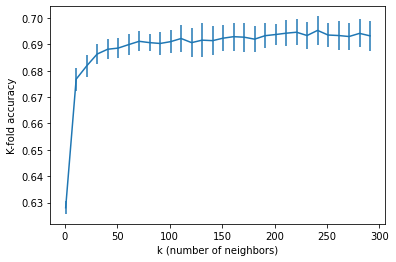

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

Using this, we can find a better choice for K.

In [ ]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

241


And compute the accuracy of the overall classifier on the test data, using this K.

#### To Do 9: Evaluate your final classifier on the test set

Finally, evaluate the classifier accuracy on the test set. Print the test accuracy. Are you able to achieve at least 80% accuracy?

In [ ]:
# TODO 9 - Evaluate on test set

In [ ]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.6950292397660819

### To Do 10: Discussion

Discuss the final classifier you developed. Does it perform well? Do you have ideas that you think could make it better? Do you think other models we studied, such as a logistic regression classifier, would be a better choice for this task?

Look at some specific examples where your model does poorly. Do you notice any systematic problems?

In the examples where the model does not predict the correct 2016 vote, is it because the test sample has a different vote than training samples that are generally very similar? Or is it because the nearest neighbors are not really very similar to the test sample? Show specific examples to support your answer.

It perfroms ok, not very optimal because it's not above 80%. I think partially because I only used the features that I chose by my human-insights instead of a machine learning method like greedy feature selection. Based on my X2 scores calculation, out of 8 features, I was only able to obtain 2 that are significant in a comparison with the remaining features but not significant enough if soly looking at the X2 scores themselves. I assume out of so many other features, if I could use greedy feature selection to check through every possible combination, I might be able to raise the accuracy into 70%+.
I believer if I use a logistic regression classifier to determine which features are more useful than the others I believe the accuracy will greatly improve. Afterall, I as a human cannot do what machine is capable of to analyze through massive data in seconds.
I believe the major reason that my model's accuracy is not above 80% is due to the features that I chose. Of course there might be a better way than my current distance metric as well.


In [ ]:
yy = pd.DataFrame(y_pred)
print(yy.value_counts())
xx = pd.DataFrame(y.iloc[idx_ts])
print(xx.value_counts())
print(yy.tail())
print(xx.tail())

1    3712
0    3128
dtype: int64
PRES
0       3640
1       3200
dtype: int64
      0
6835  1
6836  0
6837  0
6838  1
6839  0
      PRES
9144     0
4409     0
6320     0
7824     0
4012     1


In [ ]:
X_trans.loc[[4012,7824,9144]]

,MARRIED_Yes,MARRIED_No,SEX_Female,SEX_Male,NEC,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,INCOME16GEN,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,EDUC12R
4012,NaN,NaN,0.0,1.0,0.67,1.0,0.0,0.0,0.0,0.0,0.2,0.0,1.0,0.0,0.0,0.33
7824,NaN,NaN,0.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.00
9144,0.0,1.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.00


Based on the above printing
I would say that error-prone situation would most likely to happen when there are too many NaNs in the datapoint and that the model is not capable to make precise prediction with very limited information to analyze
Also that when the important/significant feature has NaNs i.e. Marriage for the first 2 data points, since the remaining features would not provide higher predictability, the important/significant feature plays a key role in here.